<a href="https://colab.research.google.com/github/allythe/NeuralStyleTransfer_VGG16_VGG19/blob/main/Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import re

import pingouin as pg
from scipy import stats

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")
!ls "/content/drive/MyDrive/MIUN/DT088A_MachineLearning/implementation/"

Mounted at /content/drive/
Analysis.ipynb	vgg16_survey_results.csv     VGG19.ipynb
VGG16.ipynb	vgg16_survey_results.gsheet


In [ ]:

with open('/content/drive/MyDrive/MIUN/DT088A_MachineLearning/implementation/vgg16_survey_results.csv', 'r') as f:
    lines = [line.strip() for line in f if line.strip()]


In [ ]:
all_data = []

# Process each line
for line_num, line in enumerate(lines, 1):
    parts = line.split(',')

    # Skip lines that don't have enough parts
    if len(parts) < 8:
        continue

    # Extract metadata (first 8 fields)
    timestamp = parts[0]
    user_id = parts[1]
    pair_name = parts[2]
    layers_flag = int(parts[3]) if parts[3].isdigit() else 0
    weights_flag = int(parts[4]) if parts[4].isdigit() else 0
    pooling_flag = int(parts[5]) if parts[5].isdigit() else 0
    page_time = int(parts[6]) if parts[6].isdigit() else 0
    total_time = int(parts[7]) if parts[7].isdigit() else 0

    # Process remaining parts (image data)
    remaining = parts[8:]

    # Each image has 3 parts: name, style_grade, content_grade
    for i in range(0, len(remaining), 3):
        if i + 2 < len(remaining):
            image_name = remaining[i]
            style_grade = remaining[i+1]
            content_grade = remaining[i+2]

            # Skip if image name is missing or empty
            if not image_name or image_name == '':
                continue

            # Determine experiment type and extract parameters
            exp_type = None
            param1 = None
            param2 = None

            # Check for layers experiment
            if 'content_style_layers' in image_name:
                exp_type = 'layers'
                # Extract C and S parameters (e.g., C1_S2 -> C1 and S2)
                match = re.search(r'(C\d+)_(S\d+)', image_name)
                if match:
                    param1 = match.group(1)  # C parameter
                    param2 = match.group(2)  # S parameter

            # Check for weights experiment
            elif 'content_style_weights' in image_name:
                exp_type = 'weights'
                # Extract cw and sw parameters
                match = re.search(r'cw(\d+)_sw(\d+)', image_name)
                if match:
                    param1 = f"cw{match.group(1)}"  # cw parameter
                    param2 = f"sw{match.group(2)}"  # sw parameter

            # Check for pooling experiment
            elif 'pooling_max_avg' in image_name:
                exp_type = 'pooling'
                # Extract pooling type
                if 'pool_max' in image_name:
                    param1 = 'max'
                    param2 = None
                elif 'pool_avg' in image_name:
                    param1 = 'avg'
                    param2 = None

            # Skip if we couldn't determine experiment type
            if exp_type is None:
                continue

            # Convert grades to integers
            try:
                style = int(style_grade)
                content = int(content_grade)
            except (ValueError, TypeError):
                continue

            # Store the data
            all_data.append({
                'line_num': line_num,
                'timestamp': timestamp,
                'user_id': user_id,
                'pair_name': pair_name,
                'exp_type': exp_type,
                'image_name': image_name,
                'param1': param1,
                'param2': param2,
                'style_grade': style,
                'content_grade': content,
                'total_score': style + content,
                'layers_flag': layers_flag,
                'weights_flag': weights_flag,
                'pooling_flag': pooling_flag,
                'page_time': page_time,
                'total_time': total_time
            })

# Create DataFrame from collected data
df_clean = pd.DataFrame(all_data)


In [ ]:
print(f"Total records extracted: {len(df_clean)}")
print(f"\nFirst 10 records:")
print(df_clean.head(10).to_string())

print(f"\n\nDataFrame columns: {list(df_clean.columns)}")
print(f"\nUnique experiment types: {df_clean['exp_type'].unique()}")
print(f"Number of users: {df_clean['user_id'].nunique()}")
print(f"Number of image pairs: {df_clean['pair_name'].nunique()}")

# Now analyze by experiment type
print("\n" + "="*80)
print("ANALYSIS BY EXPERIMENT TYPE")
print("="*80)

Total records extracted: 977

First 10 records:
   line_num            timestamp  user_id pair_name exp_type                                              image_name     param1 param2  style_grade  content_grade  total_score  layers_flag  weights_flag  pooling_flag  page_time  total_time
0         2  2025-12-14 15:20:15  Safuan2    pair_6   layers    content_style_layers_pair_6_layers_C1_S2_vgg16_6_png         C1     S2            2              3            5            1             0             0         23          23
1         2  2025-12-14 15:20:15  Safuan2    pair_6   layers    content_style_layers_pair_6_layers_C2_S1_vgg16_6_png         C2     S1            5              3            8            1             0             0         23          23
2         2  2025-12-14 15:20:15  Safuan2    pair_6   layers    content_style_layers_pair_6_layers_C2_S2_vgg16_6_png         C2     S2            3              4            7            1             0             0         23     

In [ ]:
for exp_type in ['layers', 'weights', 'pooling']:
    exp_data = df_clean[df_clean['exp_type'] == exp_type]

    if len(exp_data) == 0:
        print(f"\nNo data for {exp_type} experiment")
        continue

    print(f"\n{'='*60}")
    print(f"{exp_type.upper()} EXPERIMENT")
    print(f"{'='*60}")
    print(f"Total ratings: {len(exp_data)}")
    print(f"Unique users: {exp_data['user_id'].nunique()}")
    print(f"Average style grade: {exp_data['style_grade'].mean():.2f}")
    print(f"Average content grade: {exp_data['content_grade'].mean():.2f}")

    if exp_type == 'layers':
        # For layers, we have param1=C and param2=S
        # Create combined parameter
        exp_data['combined_param'] = exp_data['param1'] + '_' + exp_data['param2']

        # Group by combined parameter
        grouped = exp_data.groupby('combined_param').agg({
            'style_grade': ['mean', 'std', 'count'],
            'content_grade': ['mean', 'std'],
            'total_score': 'mean'
        }).round(2)

        # Flatten column names
        grouped.columns = ['_'.join(col).strip() for col in grouped.columns.values]
        grouped = grouped.reset_index()

        print("\nRanking by Style Grade:")
        style_rank = grouped.sort_values('style_grade_mean', ascending=False)
        for i, (_, row) in enumerate(style_rank.iterrows(), 1):
            print(f"{i:2}. {row['combined_param']:10} {row['style_grade_mean']:5.2f} "
                  f"(±{row['style_grade_std']:.2f}, n={int(row['style_grade_count'])})")

        print("\nRanking by Content Grade:")
        content_rank = grouped.sort_values('content_grade_mean', ascending=False)
        for i, (_, row) in enumerate(content_rank.iterrows(), 1):
            print(f"{i:2}. {row['combined_param']:10} {row['content_grade_mean']:5.2f} "
                  f"(±{row['content_grade_std']:.2f})")

        print("\nRanking by Total Score (Style + Content):")
        total_rank = grouped.sort_values('total_score_mean', ascending=False)
        for i, (_, row) in enumerate(total_rank.iterrows(), 1):
            total = row['style_grade_mean'] + row['content_grade_mean']
            print(f"{i:2}. {row['combined_param']:10} {total:5.2f} "
                  f"(Style: {row['style_grade_mean']:.1f}, Content: {row['content_grade_mean']:.1f})")

    elif exp_type == 'weights':
        # For weights, param1=cw and param2=sw
        exp_data['combined_param'] = exp_data['param1'] + '_' + exp_data['param2']

        # Group by combined parameter
        grouped = exp_data.groupby('combined_param').agg({
            'style_grade': ['mean', 'std', 'count'],
            'content_grade': ['mean', 'std'],
            'total_score': 'mean'
        }).round(2)

        grouped.columns = ['_'.join(col).strip() for col in grouped.columns.values]
        grouped = grouped.reset_index()

        print("\nRanking by Style Grade:")
        style_rank = grouped.sort_values('style_grade_mean', ascending=False)
        for i, (_, row) in enumerate(style_rank.iterrows(), 1):
            print(f"{i:2}. {row['combined_param']:15} {row['style_grade_mean']:5.2f} "
                  f"(±{row['style_grade_std']:.2f}, n={int(row['style_grade_count'])})")

        print("\nRanking by Content Grade:")
        content_rank = grouped.sort_values('content_grade_mean', ascending=False)
        for i, (_, row) in enumerate(content_rank.iterrows(), 1):
            print(f"{i:2}. {row['combined_param']:15} {row['content_grade_mean']:5.2f} "
                  f"(±{row['content_grade_std']:.2f})")

        print("\nRanking by Total Score (Style + Content):")
        total_rank = grouped.sort_values('total_score_mean', ascending=False)
        for i, (_, row) in enumerate(total_rank.iterrows(), 1):
            total = row['style_grade_mean'] + row['content_grade_mean']
            print(f"{i:2}. {row['combined_param']:15} {total:5.2f} "
                  f"(Style: {row['style_grade_mean']:.1f}, Content: {row['content_grade_mean']:.1f})")

    elif exp_type == 'pooling':
        # For pooling, only param1 matters (max or avg)
        grouped = exp_data.groupby('param1').agg({
            'style_grade': ['mean', 'std', 'count'],
            'content_grade': ['mean', 'std'],
            'total_score': 'mean'
        }).round(2)

        grouped.columns = ['_'.join(col).strip() for col in grouped.columns.values]
        grouped = grouped.reset_index()

        print("\nComparison of Pooling Methods:")
        for _, row in grouped.iterrows():
            total = row['style_grade_mean'] + row['content_grade_mean']
            print(f"{row['param1']:10} pooling:")
            print(f"  Style:    {row['style_grade_mean']:.2f} (±{row['style_grade_std']:.2f})")
            print(f"  Content:  {row['content_grade_mean']:.2f} (±{row['content_grade_std']:.2f})")
            print(f"  Total:    {total:.2f} (n={int(row['style_grade_count'])})")



LAYERS EXPERIMENT
Total ratings: 464
Unique users: 15
Average style grade: 2.78
Average content grade: 3.15

Ranking by Style Grade:
 1. C2_S5       3.10 (±1.15, n=58)
 2. C2_S4       2.98 (±1.15, n=58)
 3. C3_S2       2.91 (±0.88, n=58)
 4. C4_S2       2.84 (±0.99, n=58)
 5. C2_S3       2.79 (±0.99, n=58)
 6. C1_S2       2.62 (±1.06, n=58)
 7. C2_S2       2.55 (±0.94, n=58)
 8. C2_S1       2.41 (±1.24, n=58)

Ranking by Content Grade:
 1. C2_S1       4.10 (±1.02)
 2. C4_S2       3.62 (±1.04)
 3. C3_S2       3.48 (±1.03)
 4. C2_S2       3.02 (±1.05)
 5. C2_S3       2.83 (±1.16)
 6. C2_S4       2.78 (±1.16)
 7. C2_S5       2.76 (±1.17)
 8. C1_S2       2.62 (±1.20)

Ranking by Total Score (Style + Content):
 1. C2_S1       6.51 (Style: 2.4, Content: 4.1)
 2. C4_S2       6.46 (Style: 2.8, Content: 3.6)
 3. C3_S2       6.39 (Style: 2.9, Content: 3.5)
 4. C2_S5       5.86 (Style: 3.1, Content: 2.8)
 5. C2_S4       5.76 (Style: 3.0, Content: 2.8)
 6. C2_S3       5.62 (Style: 2.8, Content: 2

/tmp/ipython-input-1501678699.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp_data['combined_param'] = exp_data['param1'] + '_' + exp_data['param2']
/tmp/ipython-input-1501678699.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp_data['combined_param'] = exp_data['param1'] + '_' + exp_data['param2']


/tmp/ipython-input-1472893110.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipython-input-1472893110.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipython-input-1472893110.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipython-input-1472893110.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipython-input-1472893110.py:33: UserWarning: set_ticklabels() s

Figure saved to: figures/mos_analysis.png


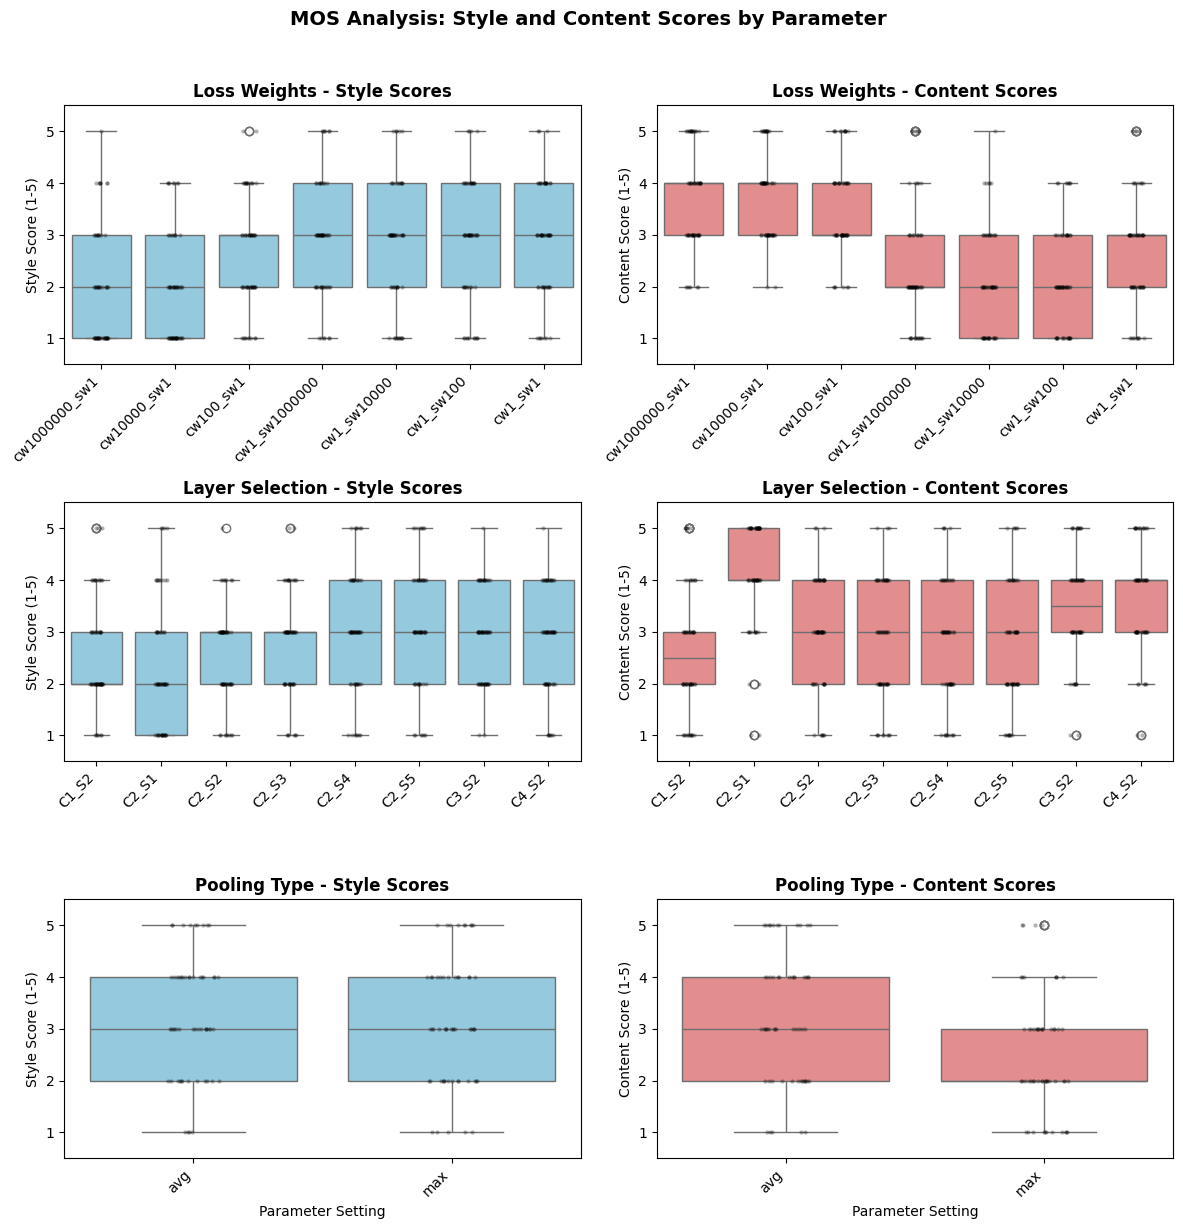

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_experiment_results_transposed(df_clean,  save_path='figures/mos_analysis.png'):
    """
    Create boxplots: Style and Content in columns, Experiments in rows.
    """
    # Prepare data
    df = df_clean.copy()
    df['parameter'] = df.apply(
        lambda row: f"{row['param1']}_{row['param2']}" if row['exp_type'] in ['layers', 'weights']
        else row['param1'],
        axis=1
    )

    # Create figure: 3 rows (experiments) × 2 columns (style/content)
    fig, axes = plt.subplots(3, 2, figsize=(12, 12))

    experiments = ['weights', 'layers', 'pooling']
    titles = ['Loss Weights', 'Layer Selection', 'Pooling Type']

    for row, (exp_type, title) in enumerate(zip(experiments, titles)):
        exp_data = df[df['exp_type'] == exp_type]

        # COLUMN 0: STYLE SCORES
        ax = axes[row, 0]
        sns.boxplot(data=exp_data, x='parameter', y='style_grade', ax=ax, color='skyblue')
        sns.stripplot(data=exp_data, x='parameter', y='style_grade',
                      ax=ax, color='black', alpha=0.3, size=3, jitter=True)
        ax.set_title(f'{title} - Style Scores', fontweight='bold')
        ax.set_xlabel('Parameter Setting' if row == 2 else '')  # Only bottom row
        ax.set_ylabel('Style Score (1-5)')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        ax.set_ylim(0.5, 5.5)
        ax.set_yticks([1, 2, 3, 4, 5])

        # COLUMN 1: CONTENT SCORES
        ax = axes[row, 1]
        sns.boxplot(data=exp_data, x='parameter', y='content_grade', ax=ax, color='lightcoral')
        sns.stripplot(data=exp_data, x='parameter', y='content_grade',
                      ax=ax, color='black', alpha=0.3, size=3, jitter=True)
        ax.set_title(f'{title} - Content Scores', fontweight='bold')
        ax.set_xlabel('Parameter Setting' if row == 2 else '')  # Only bottom row
        ax.set_ylabel('Content Score (1-5)')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        ax.set_ylim(0.5, 5.5)
        ax.set_yticks([1, 2, 3, 4, 5])

    plt.suptitle('MOS Analysis: Style and Content Scores by Parameter', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()

    # Save figure
    os.makedirs(os.path.dirname(save_path), exist_ok=True)  # Create directory if needed
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Figure saved to: {save_path}")

    plt.show()

    return fig

# Usage
fig = plot_experiment_results_transposed(df_clean, save_path='figures/mos_analysis.png')


In [ ]:
import pandas as pd
import numpy as np
from tabulate import tabulate

# Create results table
df = df_clean.copy()
df['parameter'] = df.apply(
    lambda row: f"{row['param1']}_{row['param2']}" if row['exp_type'] in ['layers', 'weights']
    else row['param1'],
    axis=1
)

rows = []
for exp_type in ['weights', 'layers', 'pooling']:
    exp_data = df[df['exp_type'] == exp_type]
    for param in sorted(exp_data['parameter'].unique()):
        param_data = exp_data[exp_data['parameter'] == param]

        style_mean = param_data['style_grade'].mean()
        style_std = param_data['style_grade'].std()
        content_mean = param_data['content_grade'].mean()
        content_std = param_data['content_grade'].std()

        # Calculate total (sum of style + content)
        total_mean = style_mean + content_mean
        # For standard deviation of sum: sqrt(var1 + var2)
        total_std = np.sqrt(style_std**2 + content_std**2)

        rows.append([
            exp_type.capitalize(),
            param,
            f"{style_mean:.2f} ± {style_std:.2f}",
            f"{content_mean:.2f} ± {content_std:.2f}",
            f"{total_mean:.2f} ± {total_std:.2f}",
            len(param_data)
        ])

# Create DataFrame
results_df = pd.DataFrame(rows, columns=['Experiment', 'Parameter', 'Style (mean±std)', 'Content (mean±std)', 'Total (mean±std)', 'N'])

# Print table
print(tabulate(results_df, headers='keys', tablefmt='grid', showindex=False))
print("\n" + "="*100)

# Print best parameters
for exp in ['Weights', 'Layers', 'Pooling']:
    exp_data = results_df[results_df['Experiment'] == exp]
    if len(exp_data) > 0:
        best_style = exp_data.loc[exp_data['Style (mean±std)'].apply(lambda x: float(x.split('±')[0])).idxmax()]
        best_content = exp_data.loc[exp_data['Content (mean±std)'].apply(lambda x: float(x.split('±')[0])).idxmax()]
        best_total = exp_data.loc[exp_data['Total (mean±std)'].apply(lambda x: float(x.split('±')[0])).idxmax()]

        print(f"{exp}:")
        print(f"  Best style = {best_style['Parameter']} ({best_style['Style (mean±std)']})")
        print(f"  Best content = {best_content['Parameter']} ({best_content['Content (mean±std)']})")
        print(f"  Best total = {best_total['Parameter']} ({best_total['Total (mean±std)']})")
        print("-"*50)

+--------------+---------------+--------------------+----------------------+--------------------+-----+
| Experiment   | Parameter     | Style (mean±std)   | Content (mean±std)   | Total (mean±std)   |   N |
+==============+===============+====================+======================+====================+=====+
| Weights      | cw1000000_sw1 | 2.00 ± 1.13        | 3.67 ± 0.97          | 5.67 ± 1.49        |  57 |
+--------------+---------------+--------------------+----------------------+--------------------+-----+
| Weights      | cw10000_sw1   | 1.95 ± 1.04        | 3.77 ± 0.85          | 5.72 ± 1.34        |  57 |
+--------------+---------------+--------------------+----------------------+--------------------+-----+
| Weights      | cw100_sw1     | 2.65 ± 1.09        | 3.58 ± 0.92          | 6.23 ± 1.43        |  57 |
+--------------+---------------+--------------------+----------------------+--------------------+-----+
| Weights      | cw1_sw1       | 2.91 ± 1.09        | 2.65 ± 1.1

In [ ]:
def analyze_experiment_with_total(df, exp_type):
    """
    Complete analysis for one experiment type, testing style, content, and total scores.
    """
    exp_data = df[df['exp_type'] == exp_type]

    # Create group column
    if exp_type in ['layers', 'weights']:
        exp_data = exp_data.copy()
        exp_data['group'] = exp_data['param1'] + '_' + exp_data['param2']
    else:
        exp_data = exp_data.copy()
        exp_data['group'] = exp_data['param1']

    # Calculate total score (style + content)
    exp_data = exp_data.copy()
    exp_data['total_score'] = exp_data['style_grade'] + exp_data['content_grade']

    print(f"\n{'='*60}")
    print(f"{exp_type.upper()} EXPERIMENT")
    print(f"{'='*60}")

    results = {}

    # 1. Analyze STYLE scores
    print(f"\n1. STYLE SCORES ANALYSIS:")
    print("-" * 40)

    style_art = art_anova(exp_data, 'group', 'style_grade')
    anova_style = style_art['anova']

    df_between = int(anova_style['DF'].iloc[0])
    df_within = int(anova_style['DF'].iloc[1])
    f_value = anova_style['F'].iloc[0]
    p_value = anova_style['p-unc'].iloc[0]

    p_str = "p < 0.001" if p_value < 0.001 else f"p = {p_value:.3f}"

    if p_value < 0.05:
        print(f"   ART revealed significant differences: F({df_between}, {df_within}) = {f_value:.2f}, {p_str}")

        # Post-hoc comparisons for style
        print(f"\n   Post-hoc pairwise comparisons:")
        posthoc_style = art_posthoc(exp_data, 'group', 'style_grade')
        for _, row in posthoc_style.iterrows():
            sig = "✓ SIGNIFICANT" if row['significant'] else "✗ Not significant"
            print(f"     • {row['Group_A']} (Mdn={row['Mdn_A']:.1f}, IQR={row['IQR_A']:.1f}) vs "
                  f"{row['Group_B']} (Mdn={row['Mdn_B']:.1f}, IQR={row['IQR_B']:.1f}): "
                  f"{sig} (p={row['p_corr']:.4f})")
    else:
        print(f"   No significant differences: F({df_between}, {df_within}) = {f_value:.2f}, {p_str}")

    # 2. Analyze CONTENT scores
    print(f"\n2. CONTENT SCORES ANALYSIS:")
    print("-" * 40)

    content_art = art_anova(exp_data, 'group', 'content_grade')
    anova_content = content_art['anova']

    df_between_c = int(anova_content['DF'].iloc[0])
    df_within_c = int(anova_content['DF'].iloc[1])
    f_value_c = anova_content['F'].iloc[0]
    p_value_c = anova_content['p-unc'].iloc[0]

    p_str_c = "p < 0.001" if p_value_c < 0.001 else f"p = {p_value_c:.3f}"

    if p_value_c < 0.05:
        print(f"   ART revealed significant differences: F({df_between_c}, {df_within_c}) = {f_value_c:.2f}, {p_str_c}")

        # Post-hoc comparisons for content
        print(f"\n   Post-hoc pairwise comparisons:")
        posthoc_content = art_posthoc(exp_data, 'group', 'content_grade')
        for _, row in posthoc_content.iterrows():
            sig = "✓ SIGNIFICANT" if row['significant'] else "✗ Not significant"
            print(f"     • {row['Group_A']} (Mdn={row['Mdn_A']:.1f}, IQR={row['IQR_A']:.1f}) vs "
                  f"{row['Group_B']} (Mdn={row['Mdn_B']:.1f}, IQR={row['IQR_B']:.1f}): "
                  f"{sig} (p={row['p_corr']:.4f})")
    else:
        print(f"   No significant differences: F({df_between_c}, {df_within_c}) = {f_value_c:.2f}, {p_str_c}")

    # 3. Analyze TOTAL scores (style + content)
    print(f"\n3. TOTAL SCORES ANALYSIS (Style + Content):")
    print("-" * 40)

    total_art = art_anova(exp_data, 'group', 'total_score')
    anova_total = total_art['anova']

    df_between_t = int(anova_total['DF'].iloc[0])
    df_within_t = int(anova_total['DF'].iloc[1])
    f_value_t = anova_total['F'].iloc[0]
    p_value_t = anova_total['p-unc'].iloc[0]

    p_str_t = "p < 0.001" if p_value_t < 0.001 else f"p = {p_value_t:.3f}"

    if p_value_t < 0.05:
        print(f"   ART revealed significant differences: F({df_between_t}, {df_within_t}) = {f_value_t:.2f}, {p_str_t}")

        # Post-hoc comparisons for total
        print(f"\n   Post-hoc pairwise comparisons:")
        posthoc_total = art_posthoc(exp_data, 'group', 'total_score')
        for _, row in posthoc_total.iterrows():
            sig = "✓ SIGNIFICANT" if row['significant'] else "✗ Not significant"
            print(f"     • {row['Group_A']} (Mdn={row['Mdn_A']:.1f}, IQR={row['IQR_A']:.1f}) vs "
                  f"{row['Group_B']} (Mdn={row['Mdn_B']:.1f}, IQR={row['IQR_B']:.1f}): "
                  f"{sig} (p={row['p_corr']:.4f})")
    else:
        print(f"   No significant differences: F({df_between_t}, {df_within_t}) = {f_value_t:.2f}, {p_str_t}")

    # Store results
    results['style'] = style_art
    results['content'] = content_art
    results['total'] = total_art
    results['posthoc_style'] = posthoc_style if p_value < 0.05 else None
    results['posthoc_content'] = posthoc_content if p_value_c < 0.05 else None
    results['posthoc_total'] = posthoc_total if p_value_t < 0.05 else None

    return results

def run_complete_analysis(df_clean):
    """
    Run complete ART analysis for all experiments.
    """
    print("COMPLETE ART ANALYSIS OF STYLE TRANSFER PARAMETERS")
    print("="*70)

    all_results = {}

    for exp_type in ['weights', 'layers', 'pooling']:
        exp_data = df_clean[df_clean['exp_type'] == exp_type]
        if len(exp_data) > 0:
            all_results[exp_type] = analyze_experiment_with_total(df_clean, exp_type)
        else:
            print(f"\nNo data for {exp_type} experiment")

    # Print summary statistics
    print("\n" + "="*70)
    print("SUMMARY OF SIGNIFICANT FINDINGS")
    print("="*70)

    for exp_type in ['weights', 'layers', 'pooling']:
        if exp_type in all_results:
            print(f"\n{exp_type.upper()}:")

            # Check style significance
            style_p = all_results[exp_type]['style']['anova']['p-unc'].iloc[0]
            content_p = all_results[exp_type]['content']['anova']['p-unc'].iloc[0]
            total_p = all_results[exp_type]['total']['anova']['p-unc'].iloc[0]

            if style_p < 0.05:
                print(f"  • Style scores differ significantly (p = {style_p:.4f})")
            else:
                print(f"  • No significant differences in style scores (p = {style_p:.4f})")

            if content_p < 0.05:
                print(f"  • Content scores differ significantly (p = {content_p:.4f})")
            else:
                print(f"  • No significant differences in content scores (p = {content_p:.4f})")

            if total_p < 0.05:
                print(f"  • Total scores differ significantly (p = {total_p:.4f})")
            else:
                print(f"  • No significant differences in total scores (p = {total_p:.4f})")

    return all_results

# Run the complete analysis
complete_results = run_complete_analysis(df_clean)


COMPLETE ART ANALYSIS OF STYLE TRANSFER PARAMETERS

WEIGHTS EXPERIMENT

1. STYLE SCORES ANALYSIS:
----------------------------------------
   ART revealed significant differences: F(6, 392) = 2.13, p = 0.049

   Post-hoc pairwise comparisons:
     • cw1000000_sw1 (Mdn=2.0, IQR=2.0) vs cw10000_sw1 (Mdn=2.0, IQR=2.0): ✗ Not significant (p=1.0000)
     • cw1000000_sw1 (Mdn=2.0, IQR=2.0) vs cw100_sw1 (Mdn=3.0, IQR=1.0): ✗ Not significant (p=0.2361)
     • cw1000000_sw1 (Mdn=2.0, IQR=2.0) vs cw1_sw1 (Mdn=3.0, IQR=2.0): ✗ Not significant (p=1.0000)
     • cw1000000_sw1 (Mdn=2.0, IQR=2.0) vs cw1_sw100 (Mdn=3.0, IQR=2.0): ✗ Not significant (p=0.4231)
     • cw1000000_sw1 (Mdn=2.0, IQR=2.0) vs cw1_sw10000 (Mdn=3.0, IQR=2.0): ✗ Not significant (p=0.2872)
     • cw1000000_sw1 (Mdn=2.0, IQR=2.0) vs cw1_sw1000000 (Mdn=3.0, IQR=2.0): ✗ Not significant (p=1.0000)
     • cw10000_sw1 (Mdn=2.0, IQR=2.0) vs cw100_sw1 (Mdn=3.0, IQR=1.0): ✗ Not significant (p=0.8230)
     • cw10000_sw1 (Mdn=2.0, IQR=2.0) v